# DGP

In [2]:
import numpy as np

def gen_temporal_market_data(n_subjects, n_timesteps, d, base_fn, tau_fn, sigma, ar_coef=0.5, n_competitors=4, competitor_correlation=0.3,increase_trend=0, divergence=0):
    X = np.zeros((n_subjects, n_timesteps, d))
    
    for t in range(n_timesteps):
        if t == 0:
            X[:, t, :] = np.random.uniform(0, 1, size=(n_subjects, d))
        else:
            # AR(1)
            X[:, t, :] = (ar_coef * X[:, t-1, :] + 
                         (1-ar_coef) * np.random.uniform(0, 1, size=(n_subjects, d)))
    
    # Generate treatment (only one unit is treated)
    T = np.zeros((n_subjects, n_timesteps))
    treated_unit = 0
    #treated_unit = np.random.randint(0, n_subjects)  # randomly select one unit to treat
    treatment_start = round(n_timesteps // 1.5)
    T[treated_unit, treatment_start:] = 1  # treat after treatment_start

    #randomly select competitors
    competitor_idx = np.random.choice(np.arange(n_subjects)[np.arange(n_subjects) != treated_unit], n_competitors, replace=False)
    
    # Generate outcomes over time
    Y = np.zeros((n_subjects, n_timesteps))
    Y_c = np.zeros((n_subjects, n_timesteps)) #true counterfactual outcomes
    
    for t in range(n_timesteps):
        noise = sigma * np.random.normal(0, 1, size=n_subjects)
        base_outcome = base_fn(X[:, t, :])

        if t == 0:
            Y[:, t] = base_outcome + noise
            Y_c[:, t] = base_outcome + noise  # Initial counterfactual is the same
        else:
            if divergence == 0:
                Y[:, t] = ar_coef * Y[:, t-1] + base_outcome + noise
                Y[:, t] += increase_trend * t  # Add linear trend

                Y_c[:, t] = ar_coef * Y_c[:, t-1] + base_outcome + noise  # Independent counterfactual dynamics
                Y_c[:, t] += increase_trend * t  # Linear trend for counterfactual
            else:
                #hetergenous increase trend 
                Y[:, t] = ar_coef * Y[:, t-1] + base_outcome + noise
                Y[:, t] +=  increase_trend * t  
                Y[treated_unit, t] += divergence * t

                Y_c[:, t] = ar_coef * Y_c[:, t-1] + base_outcome + noise  
                Y_c[:, t] += increase_trend * t  
                Y_c[treated_unit, t] += divergence * t

            # Competitor effect (only in observed outcomes)
            competitor_mean = Y[competitor_idx, t].mean()
            treated_baseline = Y[treated_unit, t-1]
            #competitor_effect = competitor_correlation * (competitor_mean / (treated_baseline + 1e-6))
            competitor_effect = competitor_correlation * (competitor_mean)
            base = Y[treated_unit, t]
            Y[treated_unit, t] = competitor_effect + (1 - competitor_correlation) * base
            base = Y_c[treated_unit, t]
            Y_c[treated_unit, t] = competitor_effect + (1 - competitor_correlation) * base

        # Add treatment effect (only in observed outcomes)
        if t >= treatment_start:
            treatment_effect = tau_fn(X[treated_unit, t, :])
            Y[treated_unit, t] += treatment_effect
    
    return Y, T, X, treated_unit, competitor_idx, Y_c

def get_market_data_generator(n_subjects, n_timesteps, d, sigma, n_competitors, competitor_correlation=0.3, setup = 'A', increase_trend=0,divergence=0):
    if setup == 'A':
        def base_fn(X): 
            return (0.5 * X[:, 0] + 0.3 * X[:, 1] + 
                   0.2 * X[:, 2] + 0.4 * X[:, 3] + 0.1 * X[:, 4])
        def tau_fn(X):
            # Treatment effect (heterogeneous)
            return 5 + np.sin(2 * np.pi * X[0])
    elif setup == 'B':
        def base_fn(X): 
            # Simple linear combination of features
            return (0.5 * X[:, 0] + 0.3 * X[:, 1] + 
                   0.2 * X[:, 2] + 0.4 * X[:, 3] + 0.1 * X[:, 4])
        def tau_fn(X):
            # constant treatment effect
            return 5.0
    elif setup == 'C':
        def base_fn(X): 
            return (0.5 * X[:, 0] + 0.3 * X[:, 1] + 
                   0.2 * X[:, 2] + 0.4 * X[:, 3] + 0.1 * X[:, 4])
        def tau_fn(X):
            # Treatment effect (heterogeneous)
            return 5*X[0]
    
    def gen_data_fn(): 
        return gen_temporal_market_data(n_subjects, n_timesteps, d, 
                                      base_fn, tau_fn, sigma, 
                                      n_competitors=n_competitors, 
                                      competitor_correlation=competitor_correlation, 
                                      increase_trend=increase_trend, divergence=divergence)
    
    return gen_data_fn, base_fn, tau_fn


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tau_function(tau_fn, n_points=100):
    # Create X values
    X = np.linspace(0, 1, n_points)
    
    # Calculate treatment effects
    # Reshape X to match the function's expected input format
    tau_values = np.array([tau_fn(np.array([x])) for x in X])
    
    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(X, tau_values, 'lightblue', linewidth=2)
    plt.title('Treatment Effect Function')
    plt.xlabel('X[0] value')
    plt.ylabel('Treatment Effect')
    plt.grid(False)
    plt.show()

# # Example usage with your tau_fn
# def tau_fn(X):
#     # Treatment effect (heterogeneous)
#     #return 2 * np.sin(2 * np.pi * X[0])
#     return 5

# # Plot the function
# plot_tau_function(tau_fn)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# # Plot treatments as matrix
# ax = axes[1]
# # Create matrix with treated unit first, then competitors, then some unrelated
# plot_indices = np.concatenate([[treated_unit], competitor_idx, unrelated_idx])
# treatment_matrix = T[plot_indices]
# sns.heatmap(treatment_matrix, 
#             cmap=['white', 'lightblue'],  # white for 0, blue for 1
#             cbar=False,
#             ax=ax)
# ax.set_title('Treatment Assignments Over Time')
# ax.set_xlabel('Time Steps')
# ax.set_ylabel('Units')
# # Add custom y-tick labels
# unit_labels = ['Treated'] + [f'Comp {i+1}' for i in range(len(competitor_idx))] + \
#              [f'Unrel {i+1}' for i in range(num_unrelated)]
# ax.set_yticks(np.arange(len(plot_indices)) + 0.5)
# ax.set_yticklabels(unit_labels)

def plot_temporal_data(Y, T, X, treated_unit, competitor_idx, Y_c, num_unrelated=50, figsize=(12, 6)):

    # Create figure
    plt.figure(figsize=figsize)
    ax = plt.gca()
    time_steps = np.arange(Y.shape[1])
    
    # Plot competitors
    for idx in competitor_idx:
        ax.plot(time_steps, Y[idx], 'orange', alpha=0.4, label='Related Competitor', linewidth=1)
    
    # Plot unrelated units
    unrelated_mask = ~np.isin(np.arange(len(Y)), np.append(competitor_idx, treated_unit))
    unrelated_idx = np.random.choice(np.where(unrelated_mask)[0], num_unrelated)
    for idx in unrelated_idx:
        ax.plot(time_steps, Y[idx], 'lightblue', alpha=0.4, label='Unrelated', linewidth=1)
    
    # Plot treated unit and its counterfactual
    ax.plot(time_steps, Y[treated_unit], 'r-', label='Treated Unit', linewidth=1)
    ax.plot(time_steps, Y_c[treated_unit], 'r--', label='True Counterfactual', linewidth=1)
    
    
    # Add treatment start line
    ax.axvline(x=round(len(time_steps)//1.5), color='k', linestyle='--', label='Treatment Start')
    
    # Remove duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    # Set labels and title
    ax.set_title('Outcomes Over Time')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Outcome Value')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Sample data

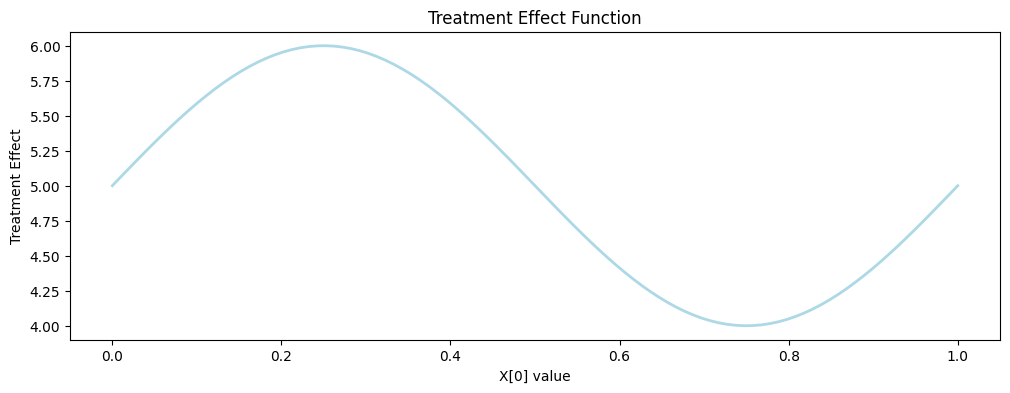

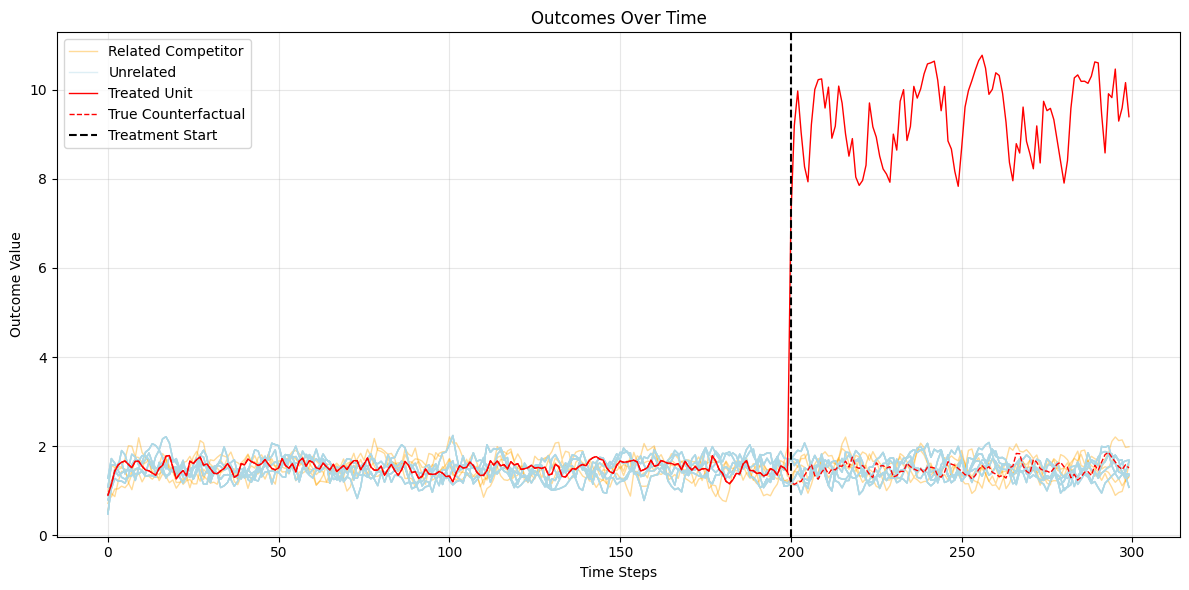

In [5]:
# Example usage
#np.random.seed(42)
n_subjects = 10
n_competitors = 4
n_timesteps = 300
d = 5
sigma = 0.1
competitor_correlation = 0.3
increase_trend = 0
divergence = 0
gen_data_fn, base_fn, tau_fn = get_market_data_generator(
    n_subjects, n_timesteps, d, sigma, n_competitors=n_competitors, 
    competitor_correlation=competitor_correlation, setup = 'A', increase_trend=increase_trend, divergence=divergence)

Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()
plot_tau_function(tau_fn)
plot_temporal_data(Y, T, X, treated_unit, competitor_idx,Y_c)

In [7]:
import pandas as pd
import numpy as np

def create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx, save_path=None):
    n_subjects, n_timesteps, n_features = X.shape
    
    # Create multi-index data
    panel_data = []
    
    for subject in range(n_subjects):
        # Determine unit type
        is_treated = (subject == treated_unit)
        is_competitor = subject in competitor_idx
        
        for time in range(n_timesteps):
            row = {
                'subject_id': subject,
                'time': time,
                'Y': Y[subject, time],
                'Y_c': Y_c[subject, time],
                'T': T[subject, time],
                'unit_type': 'treated' if is_treated else ('competitor' if is_competitor else 'other'),
                'is_post': time >= round(n_timesteps//1.5)
            }
            
            # Add features
            for j in range(n_features):
                row[f'X{j}'] = X[subject, time, j]
            
            panel_data.append(row)
    
    # Convert to DataFrame
    df = pd.DataFrame(panel_data)
    
    # # Set multi-index
    # df = df.set_index(['subject_id', 'time'])
    
    # Save if path provided
    if save_path:
        df.to_csv(save_path)
    
    return df


In [8]:
# Convert to panel data
df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)
df


,subject_id,time,Y,Y_c,T,unit_type,is_post,X0,X1,X2,X3,X4
0,0,0,0.897618,0.897618,0.0,treated,False,0.962175,0.301914,0.324868,0.612327,0.167083
1,0,1,1.139083,1.139083,0.0,treated,False,0.800519,0.451094,0.203398,0.359865,0.320172
2,0,2,1.439459,1.439459,0.0,treated,False,0.860163,0.566121,0.550855,0.604934,0.407511
3,0,3,1.578543,1.578543,0.0,treated,False,0.867711,0.414104,0.689821,0.555812,0.480428
4,0,4,1.638512,1.638512,0.0,treated,False,0.881907,0.505359,0.455723,0.477019,0.649295
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,9,295,1.400515,1.400515,0.0,other,True,0.713844,0.607385,0.546650,0.314424,0.265648
2996,9,296,1.530782,1.530782,0.0,other,True,0.696638,0.731153,0.494434,0.480712,0.144493
2997,9,297,1.622269,1.622269,0.0,other,True,0.710425,0.415344,0.495782,0.470417,0.123048
2998,9,298,1.669474,1.669474,0.0,other,True,0.606234,0.699943,0.253513,0.512853,0.493109


In [13]:
# #save different setups
# setup = ['A', 'B', 'C']
# increase_trend = [0, 0.01]
# trend_index = ['no','yes']
# for s in setup:
#     for t,t_index in zip(increase_trend,trend_index):
#         np.random.seed(42)
#         gen_data_fn, base_fn, tau_fn = get_market_data_generator(
#             n_subjects, n_timesteps, d, sigma, n_competitors=n_competitors, 
#             competitor_correlation=competitor_correlation, setup=s, increase_trend=t)
#         Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()
#         df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)
#         df.to_csv(f'../data/panel_data_n10_t300_setup{s}_trend{t_index}.csv')


# USE SC

In [9]:
import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
style.use('ggplot')

from scipy.optimize import fmin_slsqp
from typing import List
from operator import add
from toolz import reduce, partial

In [10]:
#Define the loss function:
def loss(W,X,Y):
    return np.sqrt(np.mean((Y - X.dot(W))**2))

def calculate_W(X,Y):
    #set initial weights as 1/number of features
    W_initial = np.ones(X.shape[1])/X.shape[1]
    #bound the weights between 0 and 1
    W = fmin_slsqp(partial(loss, X=X, Y=Y), W_initial,f_eqcons=lambda W: np.sum(W)-1, bounds=[(0,1)]*X.shape[1], disp=False)
    return W

def evaluate_sc(df, treated_unit, competitor_idx, tau_fn, show = True):
    # Split pre and post periods
    treated = df[df['subject_id'] == treated_unit]
    df_pre = df[df['is_post'] == False]
    df_post = df[df['is_post'] == True]
    
    # Calculate synthetic control weights using pre-treatment data
    df_pre_Y = df_pre.pivot(index='time', columns='subject_id')['Y']
    X = df_pre_Y.drop(columns=treated_unit).values
    Y = df_pre_Y[treated_unit].values
    weights = calculate_W(X, Y)
    
    # Get treated and synthetic outcomes for all periods
    df_Y = df.pivot(index='time', columns='subject_id')['Y']
    df_Y_c = df.pivot(index='time', columns='subject_id')['Y_c']
    treated_outcomes = df_Y[treated_unit].values
    treated_counterfactual = df_Y_c[treated_unit].values
    synthetic_outcomes = df_Y.drop(columns=treated_unit).values.dot(weights)
    
    # Calculate observed treatment effects (ATT)
    att = treated_outcomes - synthetic_outcomes
    
    # Calculate true treatment effects for each post-treatment period
    post_periods = df_post['time'].unique()
    true_effects = []
    
    for t in post_periods:
        # Get X values for treated unit at time t
        X_t = df[df['time'] == t].loc[df['subject_id'] == treated_unit, ['X0','X1','X2','X3','X4']].values[0]
        true_tau_t = tau_fn(X_t)
        true_effects.append(true_tau_t)
    
    true_effects = np.array(true_effects)
    
    # Calculate performance metrics
    post_att = att[len(df_pre_Y):]  # Get only post-treatment ATT
    mse = np.mean((post_att - true_effects)**2)
    mae = np.mean(np.abs(post_att - true_effects))
    bias = np.mean(post_att - true_effects)
    
    if show:
        # Print results
        print("\nPerformance Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Bias: {bias:.4f}")

        plt.figure(figsize=(12,2))
        plt.axvline(x=200, color='lightblue', linestyle='--')
        plt.plot(treated['time'], treated['Y'], label='Treated')
        plt.plot(treated['time'], treated_counterfactual, label='True Counterfactual')
        plt.plot(treated['time'], synthetic_outcomes, label='Synthetic Treated')
        plt.xlabel('Time')
        plt.ylabel('Y')
        plt.title('Time Series of the Treated vs Synthetic Treated (Synthetic Control)')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12,2))
        plt.plot(treated['time'], att)
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.axvline(x=200, color='lightblue', linestyle='--')
        plt.xlabel('Time')
        plt.ylabel('Y')
        plt.title('Estimated Treatment Effect (ATT)')
        plt.show()
    
        plt.figure(figsize=(12,2))
        time_points = np.arange(len(post_periods))
        plt.plot(time_points, post_att, 'lightblue', label='Estimated Effect (Synthetic Control)', linewidth=2)
        plt.plot(time_points, true_effects, 'orange', label='True Effect', linewidth=2)
        plt.title('Estimated vs True Treatment Effects')
        plt.xlabel('Time since treatment')
        plt.ylabel('Effect Size')
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.show()
    
    return {
        'mse': mse,
        'mae': mae,
        'bias': bias,
        'estimated_effects': post_att,
        'true_effects': true_effects,
        'weights': weights
    }


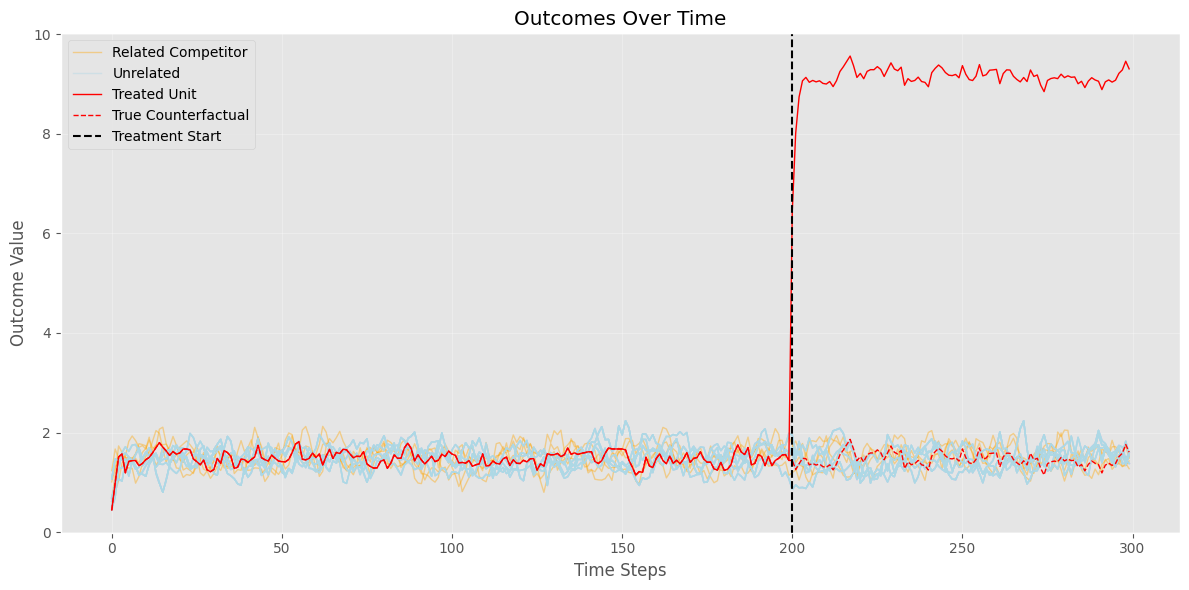


Performance Metrics:
MSE: 6.9691
MAE: 2.6194
Bias: 2.6170


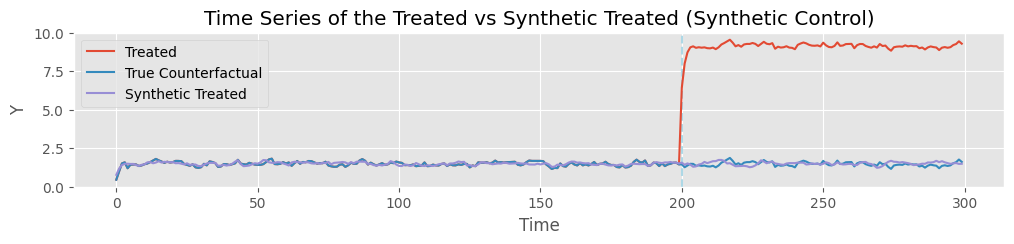

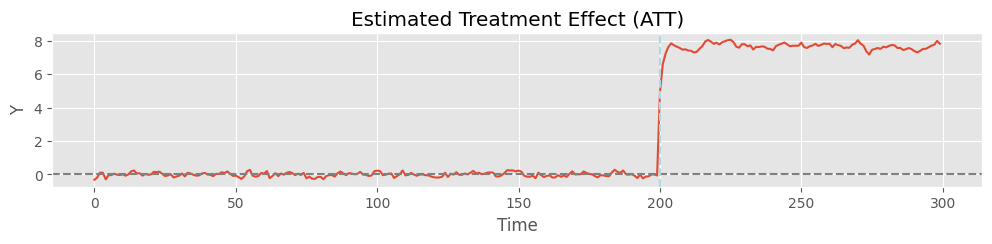

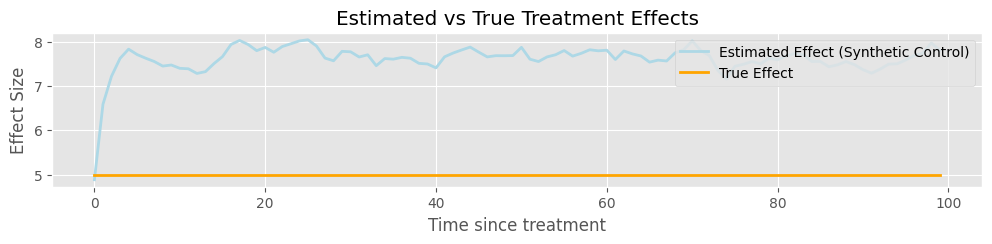

In [12]:
#test different dgp

# Example usage
#np.random.seed(42)
n_subjects = 10
n_competitors = 4
n_timesteps = 300
d = 5
sigma = 0.1
competitor_correlation = 0.3
gen_data_fn, base_fn, tau_fn = get_market_data_generator(
    n_subjects, n_timesteps, d, sigma, n_competitors=n_competitors, 
    competitor_correlation=competitor_correlation, setup = 'B', increase_trend=0, divergence=0)

Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()
plot_temporal_data(Y, T, X, treated_unit, competitor_idx,Y_c)


df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)
# Example usage
results = evaluate_sc(df, treated_unit, competitor_idx, tau_fn)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_simulation(n_subjects, n_timesteps, d, sigma, n_competitors, competitor_correlation, setups, increase_trends, n_runs=100):
    results = []  # Store results for all simulations

    for setup in setups:
        for trend in increase_trends:
            mse_list, mae_list, bias_list = [], [], []

            for run in range(n_runs):
                # Generate data for the given setup and trend
                gen_data_fn, base_fn, tau_fn = get_market_data_generator(
                    n_subjects, n_timesteps, d, sigma, 
                    n_competitors=n_competitors, 
                    competitor_correlation=competitor_correlation, 
                    setup=setup, increase_trend=trend
                )
                Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()
                
                # Create panel data for the synthetic control method
                df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)

                # Evaluate the synthetic control method
                results_dict = evaluate_sc(df, treated_unit, competitor_idx, tau_fn, show=False)
                
                # Extract metrics
                mse_list.append(results_dict['mse'])
                mae_list.append(results_dict['mae'])
                bias_list.append(results_dict['bias'])
            
            # Store average results for this setup and trend
            results.append({
                'setup': setup,
                'increase_trend': trend,
                'mse_avg': np.mean(mse_list),
                'mae_avg': np.mean(mae_list),
                'bias_avg': np.mean(bias_list)
            })

    return pd.DataFrame(results)

def plot_results(results_df):
    """Plot the metrics for different setups and trends"""
    for metric in ['mse_avg', 'mae_avg', 'bias_avg']:
        plt.figure(figsize=(12, 4))
        for setup in results_df['setup'].unique():
            subset = results_df[results_df['setup'] == setup]
            plt.plot(subset['increase_trend'], subset[metric], label=f"Setup {setup}")
        
        plt.xlabel("Increase Trend")
        plt.ylabel(metric.replace("_avg", "").upper())
        plt.title(f"{metric.replace('_avg', '').upper()} Across Setups")
        plt.legend()
        plt.grid()
        plt.show()

def plot_effects(gen_data_fn, n_timesteps):
    """Visualize the true and estimated treatment effects."""
    Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()
    treatment_effects_true = Y_c[treated_unit, :] - Y[treated_unit, :]
    treatment_effects_estimated = evaluate_treatment_effects(Y, T, treated_unit)  # Custom estimation function
    
    plt.figure(figsize=(12, 4))
    plt.plot(treatment_effects_true, label="True Effects", linestyle='--')
    plt.plot(treatment_effects_estimated, label="Estimated Effects")
    plt.axvline(n_timesteps // 1.5, color="black", linestyle="--", label="Treatment Start")
    plt.xlabel("Time Steps")
    plt.ylabel("Treatment Effect")
    plt.title("True vs Estimated Treatment Effects")
    plt.legend()
    plt.grid()
    plt.show()


,setup,increase_trend,mse_avg,mae_avg,bias_avg
0,A,0.00,7.251564,2.664015,2.662865
1,A,0.01,7.069161,2.630378,2.628567
2,A,0.05,7.255757,2.665550,2.664381
3,A,0.10,7.242464,2.661544,2.660035
4,B,0.00,7.098227,2.646336,2.645208
5,B,0.01,7.047097,2.636260,2.634089
6,B,0.05,7.132380,2.652927,2.651549
7,B,0.10,7.115869,2.649178,2.648008
8,C,0.00,2.237781,1.422198,1.421141
9,C,0.01,1.863273,1.289606,1.288605


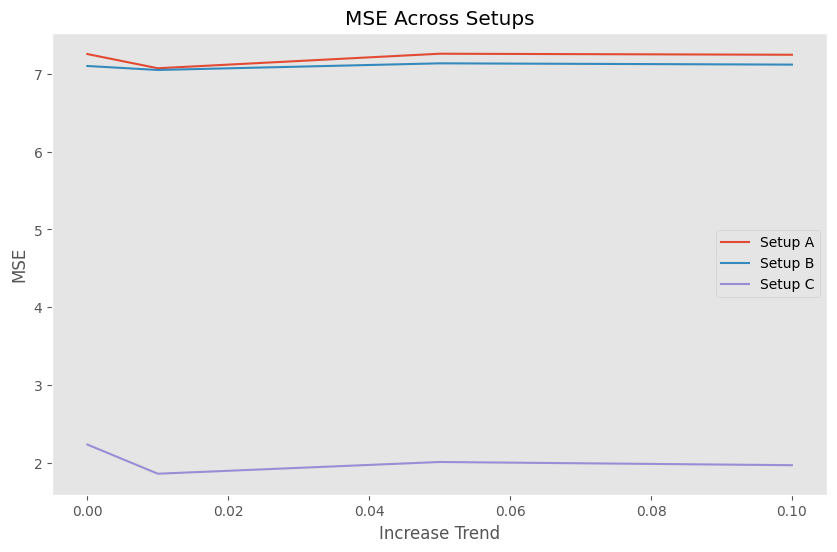

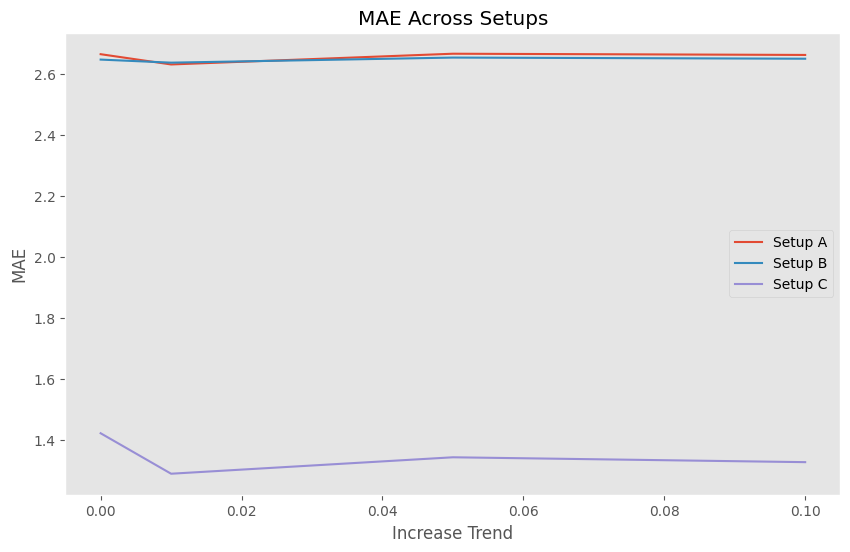

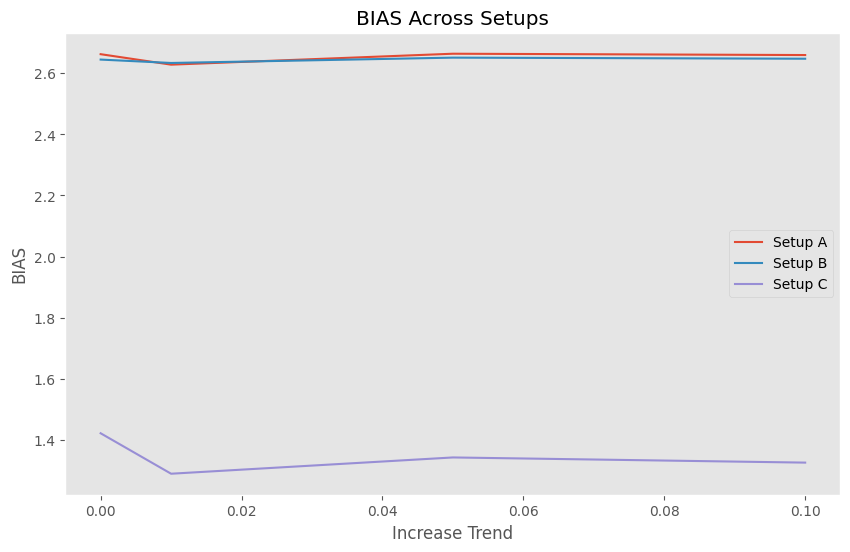

In [26]:
# Example usage
n_subjects = 10
n_competitors = 4
n_timesteps = 300
d = 5
sigma = 0.1
competitor_correlation = 0.3
setups = ['A', 'B', 'C']
increase_trends = [0, 0.01, 0.05, 0.1]

# Run simulations
results_df = run_simulation(
    n_subjects, n_timesteps, d, sigma, n_competitors, 
    competitor_correlation, setups, increase_trends, n_runs=10
)

# Display results table
display(results_df)

# Plot results
plot_results(results_df)


# Use Time Series Forecasting

In [14]:
#what if we directly use time series prediction model?
from sklearn.linear_model import LinearRegression
#more complex forecasting model

def evaluate_with_ar1(df, treated_unit, competitor_idx, tau_fn, show=True):
    att_sc = []
    att_ar1 = []
    # Split pre and post periods
    treated = df[df['subject_id'] == treated_unit]
    df_pre = df[df['is_post'] == False]
    df_post = df[df['is_post'] == True]
    
    # Calculate synthetic control weights using pre-treatment data
    df_pre_Y = df_pre.pivot(index='time', columns='subject_id')['Y']
    X_sc = df_pre_Y.drop(columns=treated_unit).values
    Y_sc = df_pre_Y[treated_unit].values
    weights = calculate_W(X_sc, Y_sc)
    
    # Get treated and synthetic outcomes for all periods
    df_Y = df.pivot(index='time', columns='subject_id')['Y']
    df_Y_c = df.pivot(index='time', columns='subject_id')['Y_c']
    treated_outcomes = df_Y[treated_unit].values
    treated_counterfactual = df_Y_c[treated_unit].values
    synthetic_outcomes = df_Y.drop(columns=treated_unit).values.dot(weights)
    
    # Train an AR(1) model using pre-treatment data for the treated unit
    treated_pre_Y = treated[treated['is_post'] == False]['Y'].values
    treated_pre_Y_lag = treated_pre_Y[:-1]  # Exclude the last observation for lag
    treated_pre_Y_target = treated_pre_Y[1:]  # Exclude the first observation for target

    ar_model = LinearRegression()
    ar_model.fit(treated_pre_Y_lag.reshape(-1, 1), treated_pre_Y_target)

    
    # Predict counterfactual using AR(1) model for the treated unit
    ar_predictions = []
    last_observed = treated_pre_Y[-1]  # Last pre-treatment observation
    for _ in range(len(df_post['time'].unique())):
        next_prediction = ar_model.predict([[last_observed]])[0]
        ar_predictions.append(next_prediction)
        last_observed = next_prediction
    
    # Calculate observed treatment effects (ATT)
    att_sc = treated_outcomes[len(df_pre_Y):] - synthetic_outcomes[len(df_pre_Y):]
    att_ar1 = treated_outcomes[len(df_pre_Y):] - np.array(ar_predictions)
    
    # Calculate true treatment effects for each post-treatment period
    post_periods = df_post['time'].unique()
    true_effects = []

    for t in post_periods:
        # Get X values for treated unit at time t
        X_t = df[df['time'] == t].loc[df['subject_id'] == treated_unit, ['X0', 'X1', 'X2', 'X3', 'X4']].values[0]
        true_tau_t = tau_fn(X_t)
        true_effects.append(true_tau_t)
    
    true_effects = np.array(true_effects)
    
    # Calculate performance metrics for both methods
    mse_sc = np.mean((att_sc - true_effects) ** 2)
    mae_sc = np.mean(np.abs(att_sc - true_effects))
    bias_sc = np.mean(att_sc - true_effects)

    mse_ar1 = np.mean((att_ar1 - true_effects) ** 2)
    mae_ar1 = np.mean(np.abs(att_ar1 - true_effects))
    bias_ar1 = np.mean(att_ar1 - true_effects)
    
    if show:
        print("\nPerformance Metrics (Synthetic Control):")
        print(f"MSE: {mse_sc:.4f}, MAE: {mae_sc:.4f}, Bias: {bias_sc:.4f}")
        print("\nPerformance Metrics (AR(1)):")
        print(f"MSE: {mse_ar1:.4f}, MAE: {mae_ar1:.4f}, Bias: {bias_ar1:.4f}")
        
        plt.figure(figsize=(12, 4))
        plt.plot(treated['time'], treated['Y'], label='Treated')
        plt.plot(post_periods, treated_counterfactual[len(df_pre_Y):], label='True Counterfactual')
        plt.plot(treated['time'], synthetic_outcomes, label='Synthetic Treated (SC)')
        plt.plot(post_periods, ar_predictions, label='AR(1) Prediction', linestyle='--')
        plt.axvline(x=200, color='lightblue', linestyle='--', label='Treatment Start')
        plt.xlabel('Time')
        plt.ylabel('Y')
        plt.title('Treated Unit vs Predictions')
        plt.legend()
        plt.grid()
        plt.show()
        
        plt.figure(figsize=(12, 4))
        time_points = np.arange(len(post_periods))
        plt.plot(time_points, att_sc, 'lightblue', label='Estimated Effect (SC)', linewidth=2)
        plt.plot(time_points, att_ar1, 'green', label='Estimated Effect (AR(1))', linewidth=2)
        plt.plot(time_points, true_effects, 'orange', label='True Effect', linewidth=2)
        plt.title('Estimated vs True Treatment Effects')
        plt.xlabel('Time since treatment')
        plt.ylabel('Effect Size')
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.show()

    return {
        'mse_sc': mse_sc,
        'mae_sc': mae_sc,
        'bias_sc': bias_sc,
        'mse_ar1': mse_ar1,
        'mae_ar1': mae_ar1,
        'bias_ar1': bias_ar1,
        'estimated_effects_sc': att_sc,
        'estimated_effects_ar1': att_ar1,
        'true_effects': true_effects,
        'weights_sc': weights
    }



Performance Metrics (Synthetic Control):
MSE: 28.3125, MAE: 5.2951, Bias: 5.2951

Performance Metrics (AR(1)):
MSE: 16.4460, MAE: 3.9633, Bias: 3.9633


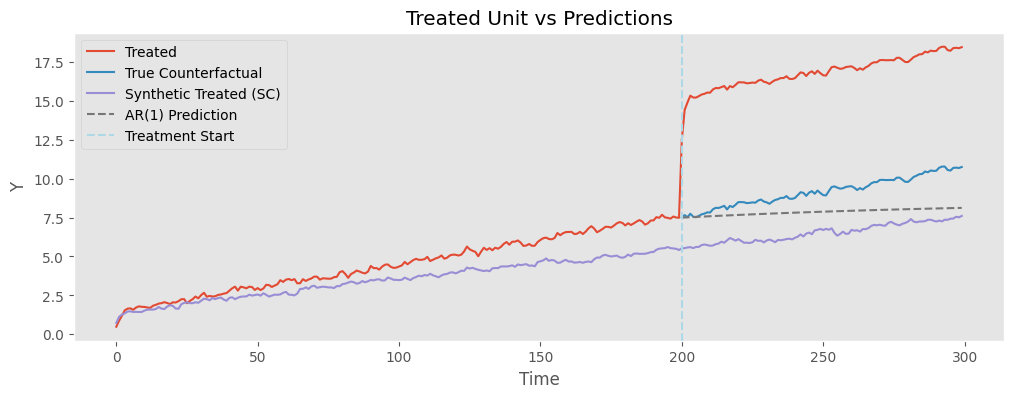

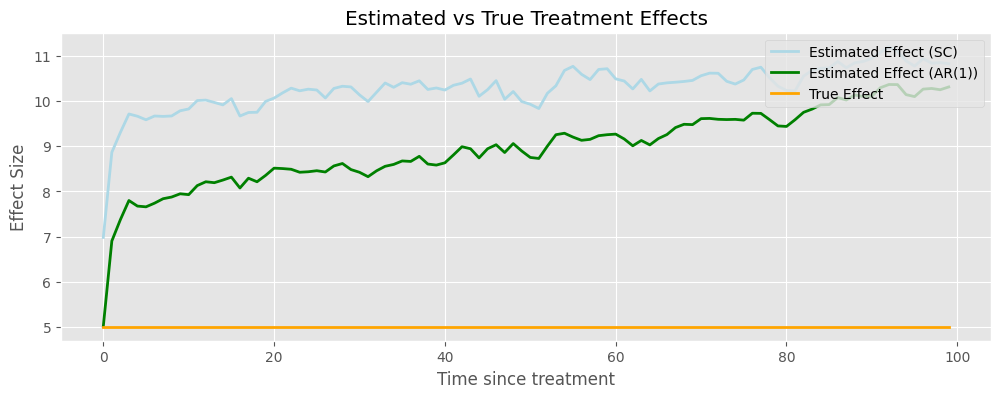

In [18]:
# Example usage
#np.random.seed(42)
n_subjects = 10
n_competitors = 4
n_timesteps = 300
d = 5
sigma = 0.1
competitor_correlation = 0.3
gen_data_fn, base_fn, tau_fn = get_market_data_generator(
    n_subjects, n_timesteps, d, sigma, n_competitors=n_competitors, 
    competitor_correlation=competitor_correlation, setup = 'B', increase_trend=0.01, divergence=0.01)

Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()
#plot_temporal_data(Y, T, X, treated_unit, competitor_idx,Y_c)

df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)
# Example usage
results = evaluate_with_ar1(df, treated_unit, competitor_idx, tau_fn)

In [19]:
def run_simulation(n_subjects, n_timesteps, d, sigmas, n_competitors_list, competitor_correlation, setups, increase_trends, divergence_trends, n_runs=10, save_df = False):
    results = []  # Store results for all simulations

    for sigma in sigmas:
        for n_competitors in n_competitors_list:
            for setup in setups:
                for trend in increase_trends:
                    for divergence in divergence_trends:
                        mse_sc_list, mae_sc_list, bias_sc_list = [], [], []
                        mse_ar1_list, mae_ar1_list, bias_ar1_list = [], [], []

                        for run in range(n_runs):
                            # Generate data for the given sigma, n_competitors, setup, and trend
                            gen_data_fn, base_fn, tau_fn = get_market_data_generator(
                                n_subjects, n_timesteps, d, sigma, 
                                n_competitors=n_competitors, 
                                competitor_correlation=competitor_correlation, 
                                setup=setup, increase_trend=trend, divergence=divergence
                            )
                            Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()

                            # Create panel data for the synthetic control method
                            df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)

                            if save_df:
                                df.to_csv(f'../data/df_sigma{sigma}_n{n_competitors}_setup{setup}_trend{trend}_divergence{divergence}_n{run}.csv', index=False)

                            # Evaluate both methods: synthetic control and AR(1)
                            results_dict = evaluate_with_ar1(df, treated_unit, competitor_idx, tau_fn, show=False)

                            # Extract metrics for synthetic control
                            mse_sc_list.append(results_dict['mse_sc'])
                            mae_sc_list.append(results_dict['mae_sc'])
                            bias_sc_list.append(results_dict['bias_sc'])

                            # Extract metrics for AR(1)
                            mse_ar1_list.append(results_dict['mse_ar1'])
                            mae_ar1_list.append(results_dict['mae_ar1'])
                            bias_ar1_list.append(results_dict['bias_ar1'])

                        # Store average results and std for this setup, sigma, and trend
                        results.append({
                            'setup': setup,
                            'sigma': sigma,
                            'n_competitors': n_competitors,
                            'increase_trend': trend,
                            'divergence': divergence,
                            'mse_sc_avg': np.mean(mse_sc_list),
                            'mse_sc_std': np.std(mse_sc_list),
                            'mae_sc_avg': np.mean(mae_sc_list),
                            'bias_sc_avg': np.mean(bias_sc_list),
                            'mse_ar1_avg': np.mean(mse_ar1_list),
                            'mse_ar1_std': np.std(mse_ar1_list),
                            'mae_ar1_avg': np.mean(mae_ar1_list),
                            'bias_ar1_avg': np.mean(bias_ar1_list),
                        })
    return pd.DataFrame(results)



In [20]:
def plot_results(results_df, comparison='Increase Trend'):
    """Plot the metrics for all setups and comparisons, averaging across setups."""
    metrics = ['mse_sc_avg', 'mse_ar1_avg']  # Focusing on MSE for simplicity
    method_labels = ['Synthetic Control', 'AR(1)']

    if comparison == 'Increase Trend':
        plt.figure(figsize=(12, 3))
        for metric, label in zip(metrics, method_labels):
            subset = results_df.groupby('increase_trend').mean(numeric_only=True).reset_index()
            plt.plot(
                subset['increase_trend'], 
                subset[metric], 
                label=label
            )
        plt.xlabel("Increase Trend")
        plt.ylabel("MSE")
        plt.title("MSE Across Increase Trends (Averaged Over Setups)")
        plt.legend()
        plt.grid()
        plt.show()

    elif comparison == 'Sigma':
        plt.figure(figsize=(12, 3))
        for metric, label in zip(metrics, method_labels):
            subset = results_df.groupby('sigma').mean(numeric_only=True).reset_index()
            plt.plot(
                subset['sigma'], 
                subset[metric], 
                label=label
            )
        plt.xlabel("Sigma")
        plt.ylabel("MSE")
        plt.title("MSE Across Sigma (Averaged Over Setups)")
        plt.legend()
        plt.grid()
        plt.show()

    elif comparison == 'Number of Competitors':
        plt.figure(figsize=(12, 3))
        for metric, label in zip(metrics, method_labels):
            subset = results_df.groupby('n_competitors').mean(numeric_only=True).reset_index()
            plt.plot(
                subset['n_competitors'], 
                subset[metric], 
                label=label
            )
        plt.xlabel("Number of Competitors")
        plt.ylabel("MSE")
        plt.title("MSE Across Number of Competitors (Averaged Over Setups)")
        plt.legend()
        plt.grid()
        plt.show()

    elif comparison == 'Divergence':
        plt.figure(figsize=(12, 3))
        for metric, label in zip(metrics, method_labels):
            subset = results_df.groupby('divergence').mean(numeric_only=True).reset_index()
            plt.plot(subset['divergence'], subset[metric], label=label)
        plt.xlabel("Divergence")
        plt.ylabel("MSE")
        plt.title("MSE Across Divergence (Averaged Over Setups)")
        plt.legend()
        plt.grid()
        plt.show()


In [22]:
#run simulations -- increased variance
# Example usage
# n_subjects = 10
# n_competitors = [4,8]
# n_timesteps = 300
# d = 5
# sigmas = [0.1, 0.5, 1]
# competitor_correlation = 0.3
# setups = ['A', 'B', 'C']
# increase_trends = [0,0.05,0.1]
# divergence_trends = [0]

n_subjects = 10
n_competitors = [4]
n_timesteps = 300
d = 5
sigmas = [0.1]
competitor_correlation = 0.3
setups = ['A', 'B', 'C']
increase_trends = [0]
divergence_trends = [0]

# Run simulations
results_df = run_simulation(
    n_subjects, n_timesteps, d, sigmas, n_competitors, 
    competitor_correlation, setups, increase_trends, divergence_trends, n_runs=10
)

# Display results table
display(results_df[['setup', 'sigma', 'n_competitors', 'increase_trend', 'divergence', 'mse_sc_avg', 'mse_sc_std','mse_ar1_avg','mse_ar1_std']])



,setup,sigma,n_competitors,increase_trend,divergence,mse_sc_avg,mse_sc_std,mse_ar1_avg,mse_ar1_std
0,A,0.1,4,0,0,7.230974,0.224187,7.177801,0.191640
1,B,0.1,4,0,0,7.148257,0.173613,7.148842,0.177232
2,C,0.1,4,0,0,1.845251,0.233676,1.871891,0.226538


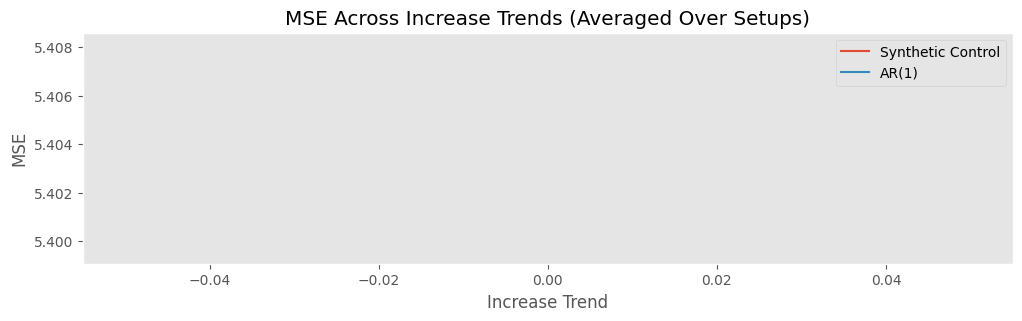

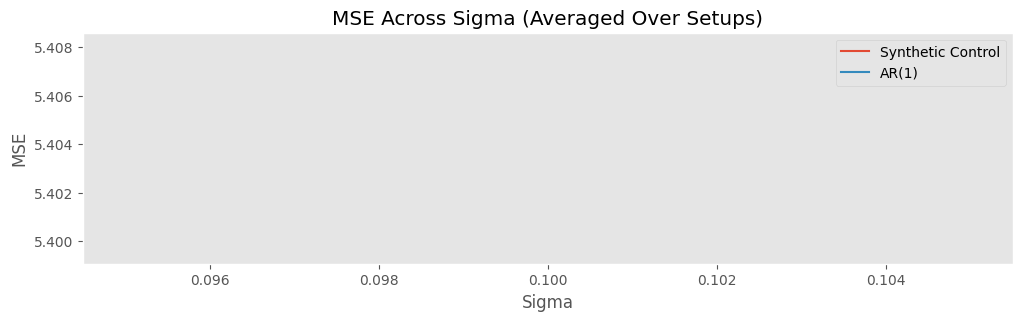

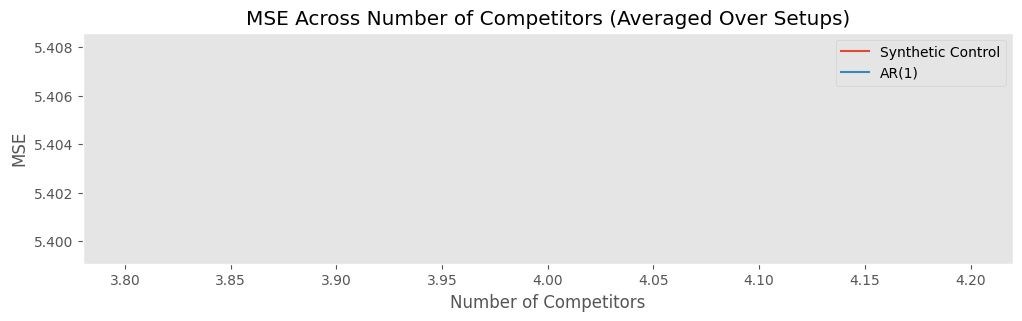

In [23]:
plot_results(results_df, comparison='Increase Trend')
plot_results(results_df, comparison='Sigma')
plot_results(results_df, comparison='Number of Competitors')


# Consider Divergent Trends

In [1]:
np.random.seed(111)
n_subjects = 10
n_competitors = 4
n_timesteps = 300
d = 5
sigma = 0.1
competitor_correlation = 0.3
increase_trend = 0.01
divergence = 0.01
gen_data_fn, base_fn, tau_fn = get_market_data_generator(
    n_subjects, n_timesteps, d, sigma, n_competitors=n_competitors, 
    competitor_correlation=competitor_correlation, setup = 'B', increase_trend=0.01, divergence=divergence)

Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()
plot_tau_function(tau_fn)
plot_temporal_data(Y, T, X, treated_unit, competitor_idx,Y_c)

df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)
#save df
df.to_csv('../data/df_divergencence_0.01_n10_t300.csv', index=False)

# Example usage
results = evaluate_with_ar1(df, treated_unit, competitor_idx, tau_fn)

NameError: name 'np' is not defined

In [140]:
def run_simulation(n_subjects, n_timesteps, d, sigma, n_competitors, competitor_correlation, setups, trend, divergence_trends, n_runs=10, save_df = False):
    results = []  # Store results for all simulations

    for setup in setups:
        for divergence in divergence_trends:
            mse_sc_list, mae_sc_list, bias_sc_list = [], [], []
            mse_ar1_list, mae_ar1_list, bias_ar1_list = [], [], []

            for run in range(n_runs):
                # Generate data for the given sigma, n_competitors, setup, and trend
                gen_data_fn, base_fn, tau_fn = get_market_data_generator(
                    n_subjects, n_timesteps, d, sigma, 
                    n_competitors=n_competitors, 
                    competitor_correlation=competitor_correlation, 
                    setup=setup, increase_trend=trend, divergence=divergence
                )
                Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()

                # Create panel data for the synthetic control method
                df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)

                if save_df:
                    df.to_csv(f'../data/df_sigma{sigma}_n{n_competitors}_setup{setup}_trend{trend}_divergence{divergence}_n{run}.csv', index=False)

                # Evaluate both methods: synthetic control and AR(1)
                results_dict = evaluate_with_ar1(df, treated_unit, competitor_idx, tau_fn, show=False)

            # Extract metrics for synthetic control
            mse_sc_list.append(results_dict['mse_sc'])
            mae_sc_list.append(results_dict['mae_sc'])
            bias_sc_list.append(results_dict['bias_sc'])

            # Extract metrics for AR(1)
            mse_ar1_list.append(results_dict['mse_ar1'])
            mae_ar1_list.append(results_dict['mae_ar1'])
            bias_ar1_list.append(results_dict['bias_ar1'])

            # Store average results and std for this setup, sigma, and trend
            results.append({
                'setup': setup,
                'sigma': sigma,
                'n_competitors': n_competitors,
                'increase_trend': trend,
                'divergence': divergence,
                'mse_sc_avg': np.mean(mse_sc_list),
                'mse_sc_std': np.std(mse_sc_list),
                'mae_sc_avg': np.mean(mae_sc_list),
                'bias_sc_avg': np.mean(bias_sc_list),
                'mse_ar1_avg': np.mean(mse_ar1_list),
                'mse_ar1_std': np.std(mse_ar1_list),
                'mae_ar1_avg': np.mean(mae_ar1_list),
                'bias_ar1_avg': np.mean(bias_ar1_list),
            })
    return pd.DataFrame(results)



,setup,sigma,n_competitors,increase_trend,divergence,mse_sc_avg,mse_sc_std,mse_ar1_avg,mse_ar1_std
0,A,0.1,4,0.01,0.00,7.253686,0.0,15.245474,0.0
1,A,0.1,4,0.01,0.01,29.168590,0.0,15.731698,0.0
2,A,0.1,4,0.01,0.02,63.960803,0.0,12.191435,0.0
3,A,0.1,4,0.01,0.03,117.687465,0.0,13.803126,0.0
4,B,0.1,4,0.01,0.00,7.103762,0.0,13.212790,0.0
5,B,0.1,4,0.01,0.01,28.644504,0.0,10.475983,0.0
6,B,0.1,4,0.01,0.02,63.798740,0.0,13.507259,0.0
7,B,0.1,4,0.01,0.03,113.492379,0.0,13.192582,0.0
8,C,0.1,4,0.01,0.00,1.834506,0.0,6.188550,0.0
9,C,0.1,4,0.01,0.01,15.236134,0.0,7.920400,0.0


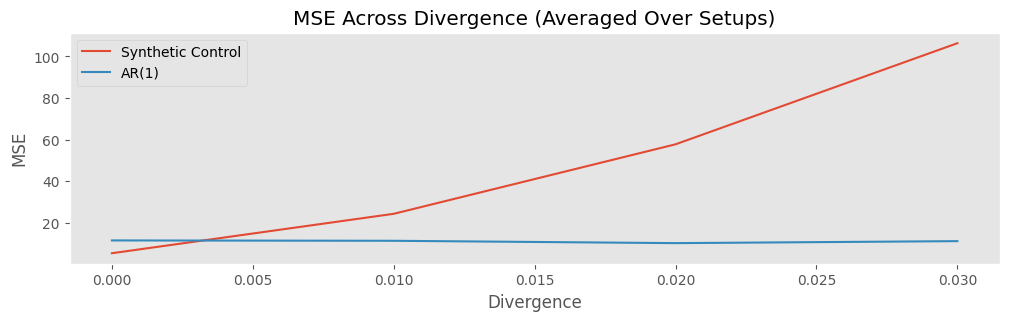

In [141]:
#run simulations -- increased variance
# Example usage
n_subjects = 10
n_competitors = 4
n_timesteps = 300
d = 5
sigmas = 0.1
competitor_correlation = 0.3
setups = ['A', 'B', 'C']
increase_trends = 0.01
divergence_trends = [0, 0.01, 0.02, 0.03]

# Run simulations
results_df2 = run_simulation(
    n_subjects, n_timesteps, d, sigmas, n_competitors, 
    competitor_correlation, setups, increase_trends, divergence_trends, n_runs=10
)

# Display results table
display(results_df2[['setup', 'sigma', 'n_competitors', 'increase_trend', 'divergence', 'mse_sc_avg', 'mse_sc_std','mse_ar1_avg','mse_ar1_std']])
plot_results(results_df2, comparison='Divergence')


# Sparse Case

In [150]:
results

{'mse_sc': np.float64(7.209969583955481),
 'mae_sc': np.float64(2.6682808065158747),
 'bias_sc': np.float64(2.6623977368611302),
 'mse_ar1': np.float64(7.40610005930643),
 'mae_ar1': np.float64(2.7031338992346314),
 'bias_ar1': np.float64(2.7010106855430407),
 'estimated_effects_sc': array([4.70584652, 6.71178164, 7.38028707, 7.53223816, 7.60279066,
        7.80137706, 7.8349506 , 7.93084727, 7.65525311, 7.80069912,
        7.8413364 , 7.78773567, 7.67672803, 7.46368947, 7.42716929,
        7.47973921, 7.54560635, 7.66918307, 7.73467155, 7.64714108,
        7.49734883, 7.49549932, 7.72246213, 7.85544367, 7.81339696,
        7.81300592, 7.83686386, 7.72648938, 7.67150694, 7.46956658,
        7.51621567, 7.73141021, 7.81595214, 7.99096057, 7.82771726,
        7.75783396, 7.87640489, 7.76351931, 7.88621357, 7.88206978,
        7.71200065, 7.61233744, 7.50752199, 7.5039958 , 7.60089865,
        7.9907439 , 7.96751353, 7.94230179, 7.99714534, 7.89714992,
        7.82706435, 7.78245399, 7.84

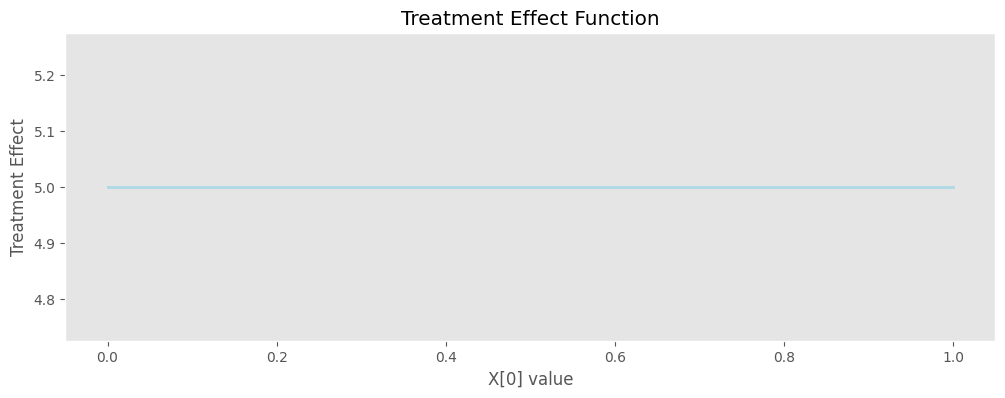

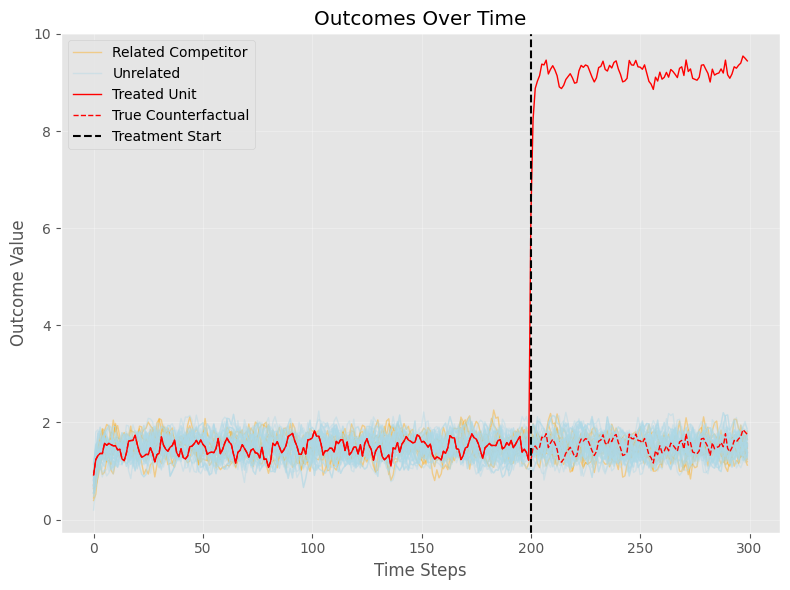


Performance Metrics (Synthetic Control):
MSE: 7.2100, MAE: 2.6683, Bias: 2.6624

Performance Metrics (AR(1)):
MSE: 7.4061, MAE: 2.7031, Bias: 2.7010


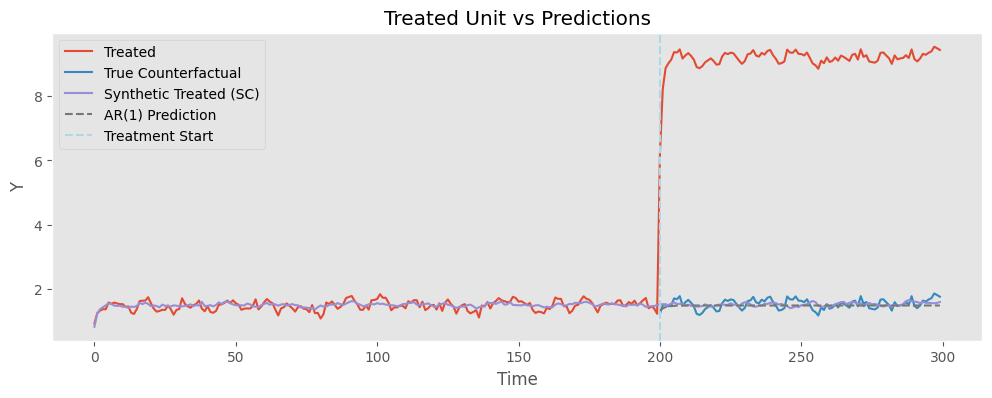

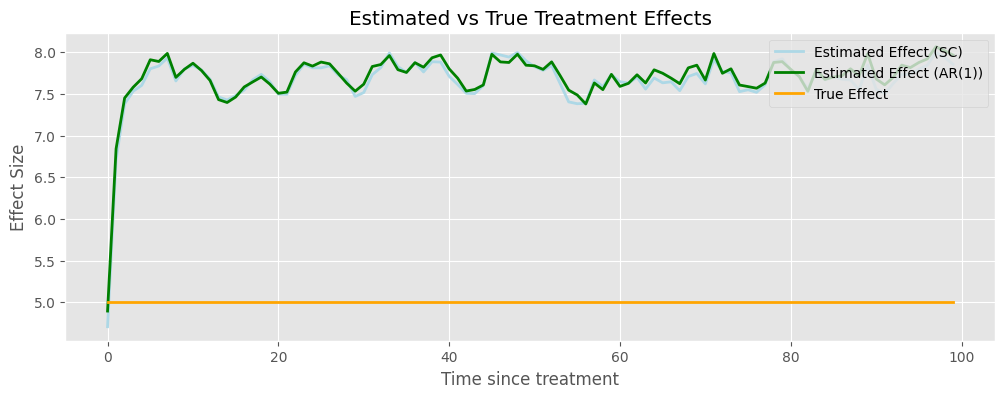

In [152]:
np.random.seed(42)
n_subjects = 100
n_competitors = 9
n_timesteps = 300
d = 5
sigma = 0.1
competitor_correlation = 0.3
increase_trend = 0
divergence = 0
gen_data_fn, base_fn, tau_fn = get_market_data_generator(
    n_subjects, n_timesteps, d, sigma, n_competitors=n_competitors, 
    competitor_correlation=competitor_correlation, setup = 'B', increase_trend=increase_trend, divergence=divergence)

Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()
plot_tau_function(tau_fn)
plot_temporal_data(Y, T, X, treated_unit, competitor_idx,Y_c)

df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)
#save df
df.to_csv('../data/df_sparse_n100_t300_B_divergence0.csv', index=False)

# Example usage
results = evaluate_with_ar1(df, treated_unit, competitor_idx, tau_fn)

#save results as txt
with open('../data/results_sparse_n100_t300_B_divergence0.txt', 'w') as f:
    f.write(str(results))  



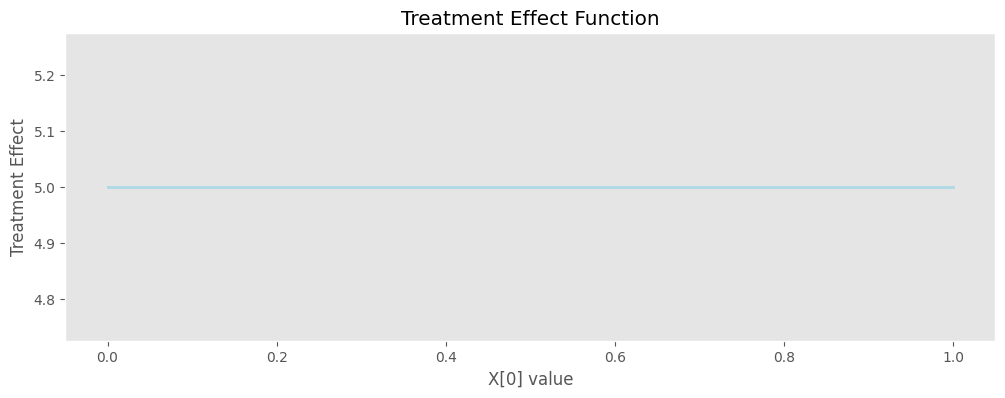

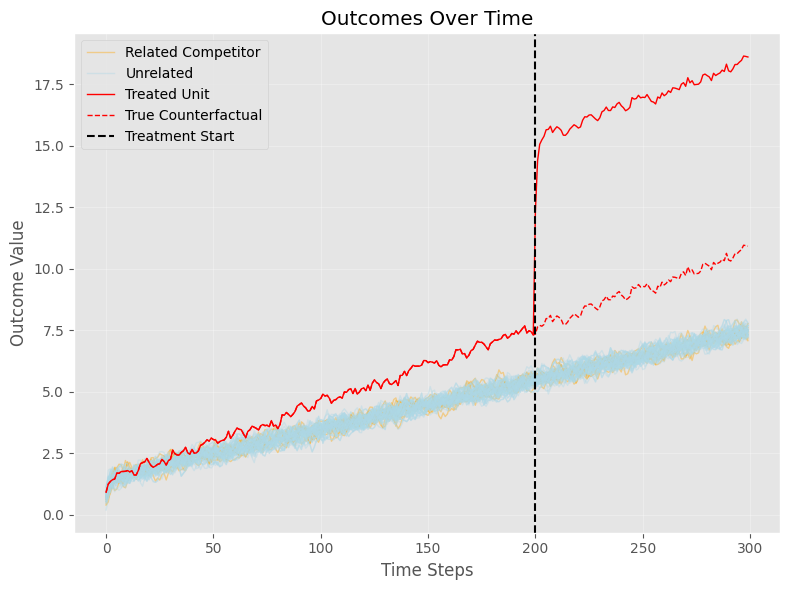


Performance Metrics (Synthetic Control):
MSE: 29.1465, MAE: 5.3720, Bias: 5.3720

Performance Metrics (AR(1)):
MSE: 16.2615, MAE: 3.9569, Bias: 3.9569


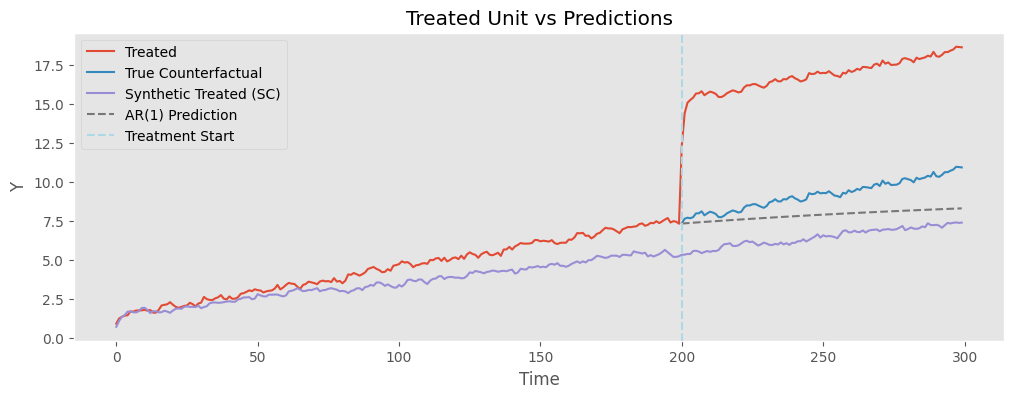

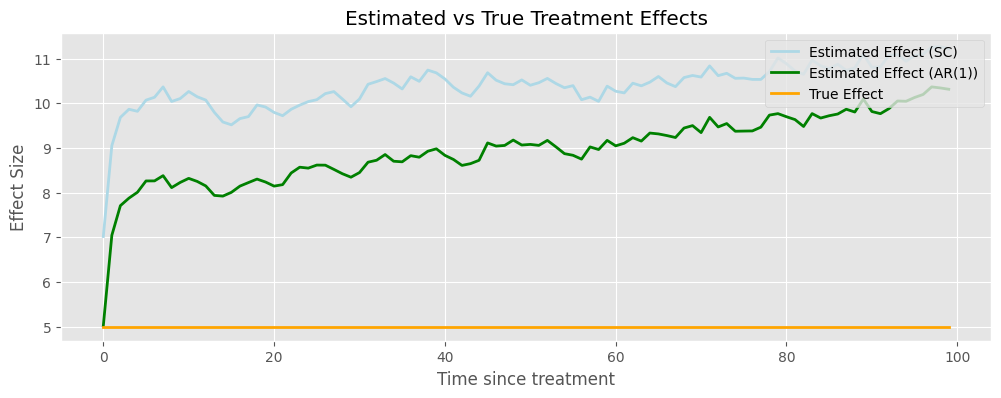

In [153]:
np.random.seed(42)
n_subjects = 100
n_competitors = 9
n_timesteps = 300
d = 5
sigma = 0.1
competitor_correlation = 0.3
increase_trend = 0.01
divergence = 0.01
gen_data_fn, base_fn, tau_fn = get_market_data_generator(
    n_subjects, n_timesteps, d, sigma, n_competitors=n_competitors, 
    competitor_correlation=competitor_correlation, setup = 'B', increase_trend=increase_trend, divergence=divergence)

Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()
plot_tau_function(tau_fn)
plot_temporal_data(Y, T, X, treated_unit, competitor_idx,Y_c)

df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)
#save df
df.to_csv('../data/df_sparse_n100_t300_B_divergence001.csv', index=False)

# Example usage
results = evaluate_with_ar1(df, treated_unit, competitor_idx, tau_fn)

#save results as txt
with open('../data/results_sparse_n100_t300_B_divergence001.txt', 'w') as f:
    f.write(str(results))  



In [137]:
def run_simulation(n_subjects, n_timesteps, d, sigmas, n_competitors_list, competitor_correlation, setups, increase_trends, divergence_trends, n_runs=10, save_df = False):
    results = []  # Store results for all simulations

    for sigma in sigmas:
            for setup in setups:
                mse_sc_list, mae_sc_list, bias_sc_list = [], [], []
                mse_ar1_list, mae_ar1_list, bias_ar1_list = [], [], []
                for run in range(n_runs):
                    # Generate data for the given sigma, n_competitors, setup, and trend
                    gen_data_fn, base_fn, tau_fn = get_market_data_generator(
                        n_subjects, n_timesteps, d, sigma, 
                        n_competitors=n_competitors_list, 
                        competitor_correlation=competitor_correlation, 
                        setup=setup, increase_trend=increase_trends, divergence=divergence_trends
                    )
                    Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()

                    # Create panel data for the synthetic control method
                    df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)

                    if save_df:
                        df.to_csv(f'../data/df_sigma{sigma}_n{n_competitors}_setup{setup}_trend{increase_trends}_divergence{divergence_trends}_n{run}.csv', index=False)

                    # Evaluate both methods: synthetic control and AR(1)
                    results_dict = evaluate_with_ar1(df, treated_unit, competitor_idx, tau_fn, show=False)

                    # Extract metrics for synthetic control
                    mse_sc_list.append(results_dict['mse_sc'])
                    mae_sc_list.append(results_dict['mae_sc'])
                    bias_sc_list.append(results_dict['bias_sc'])

                    # Extract metrics for AR(1)
                    mse_ar1_list.append(results_dict['mse_ar1'])
                    mae_ar1_list.append(results_dict['mae_ar1'])
                    bias_ar1_list.append(results_dict['bias_ar1'])

                # Store average results and std for this setup, sigma, and trend
                results.append({
                    'setup': setup,
                    'sigma': sigma,
                    'n_competitors': n_competitors_list,
                    'increase_trend': increase_trends,
                    'divergence': divergence_trends,
                    'mse_sc_avg': np.mean(mse_sc_list),
                    'mse_sc_std': np.std(mse_sc_list),
                    'mae_sc_avg': np.mean(mae_sc_list),
                    'bias_sc_avg': np.mean(bias_sc_list),
                    'mse_ar1_avg': np.mean(mse_ar1_list),
                    'mse_ar1_std': np.std(mse_ar1_list),
                    'mae_ar1_avg': np.mean(mae_ar1_list),
                    'bias_ar1_avg': np.mean(bias_ar1_list),
                })
    return pd.DataFrame(results)

In [138]:
#more competitors, less related
#run simulations -- increased variance
# Example usage
n_subjects = 100
n_competitors = 9
n_timesteps = 300
d = 5
sigmas = [0.1, 0.5, 1]
competitor_correlation = 0.3
setups = ['A', 'B', 'C']
increase_trends = 0
divergence_trends = 0

# Run simulations
results_df = run_simulation(
    n_subjects, n_timesteps, d, sigmas, n_competitors, 
    competitor_correlation, setups, increase_trends, divergence_trends, n_runs=10, save_df = True
)

#save results_df
results_df.to_csv('../data/results_df_sparse_n100_t300.csv', index=False)

# Display results table
display(results_df[['setup', 'sigma', 'n_competitors', 'increase_trend', 'divergence', 'mse_sc_avg', 'mse_sc_std','mse_ar1_avg','mse_ar1_std']])


,setup,sigma,n_competitors,increase_trend,divergence,mse_sc_avg,mse_sc_std,mse_ar1_avg,mse_ar1_std
0,A,0.1,9,0,0,6.806477,0.0,6.517651,0.0
1,B,0.1,9,0,0,6.921419,0.0,6.969529,0.0
2,C,0.1,9,0,0,1.747149,0.0,1.801995,0.0
3,A,0.5,9,0,0,6.919861,0.0,7.236247,0.0
4,B,0.5,9,0,0,6.753790,0.0,6.898131,0.0
5,C,0.5,9,0,0,1.800382,0.0,1.942195,0.0
6,A,1.0,9,0,0,9.229836,0.0,9.287854,0.0
7,B,1.0,9,0,0,8.268756,0.0,8.105478,0.0
8,C,1.0,9,0,0,2.452457,0.0,2.666855,0.0


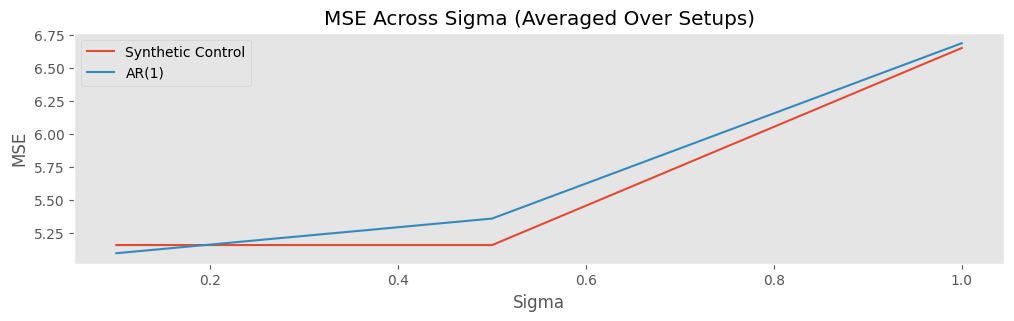

In [139]:
plot_results(results_df, comparison='Sigma')

In [142]:
def run_simulation(n_subjects, n_timesteps, d, sigma, n_competitors, competitor_correlation, setups, trend, divergence_trends, n_runs=10, save_df = False):
    results = []  # Store results for all simulations

    for setup in setups:
        for divergence in divergence_trends:
            mse_sc_list, mae_sc_list, bias_sc_list = [], [], []
            mse_ar1_list, mae_ar1_list, bias_ar1_list = [], [], []

            for run in range(n_runs):
                # Generate data for the given sigma, n_competitors, setup, and trend
                gen_data_fn, base_fn, tau_fn = get_market_data_generator(
                    n_subjects, n_timesteps, d, sigma, 
                    n_competitors=n_competitors, 
                    competitor_correlation=competitor_correlation, 
                    setup=setup, increase_trend=trend, divergence=divergence
                )
                Y, T, X, treated_unit, competitor_idx, Y_c = gen_data_fn()

                # Create panel data for the synthetic control method
                df = create_panel_data(Y, Y_c, T, X, treated_unit, competitor_idx)

                if save_df:
                    df.to_csv(f'../data/df_sigma{sigma}_n{n_competitors}_setup{setup}_trend{trend}_divergence{divergence}_n{run}.csv', index=False)

                # Evaluate both methods: synthetic control and AR(1)
                results_dict = evaluate_with_ar1(df, treated_unit, competitor_idx, tau_fn, show=False)

            # Extract metrics for synthetic control
            mse_sc_list.append(results_dict['mse_sc'])
            mae_sc_list.append(results_dict['mae_sc'])
            bias_sc_list.append(results_dict['bias_sc'])

            # Extract metrics for AR(1)
            mse_ar1_list.append(results_dict['mse_ar1'])
            mae_ar1_list.append(results_dict['mae_ar1'])
            bias_ar1_list.append(results_dict['bias_ar1'])

            # Store average results and std for this setup, sigma, and trend
            results.append({
                'setup': setup,
                'sigma': sigma,
                'n_competitors': n_competitors,
                'increase_trend': trend,
                'divergence': divergence,
                'mse_sc_avg': np.mean(mse_sc_list),
                'mse_sc_std': np.std(mse_sc_list),
                'mae_sc_avg': np.mean(mae_sc_list),
                'bias_sc_avg': np.mean(bias_sc_list),
                'mse_ar1_avg': np.mean(mse_ar1_list),
                'mse_ar1_std': np.std(mse_ar1_list),
                'mae_ar1_avg': np.mean(mae_ar1_list),
                'bias_ar1_avg': np.mean(bias_ar1_list),
            })
    return pd.DataFrame(results)



,setup,sigma,n_competitors,increase_trend,divergence,mse_sc_avg,mse_sc_std,mse_ar1_avg,mse_ar1_std
0,A,0.1,9,0.01,0.00,7.178237,0.0,15.876824,0.0
1,A,0.1,9,0.01,0.01,27.504633,0.0,12.238080,0.0
2,A,0.1,9,0.01,0.02,64.875169,0.0,9.243245,0.0
3,A,0.1,9,0.01,0.03,114.074786,0.0,13.316732,0.0
4,B,0.1,9,0.01,0.00,7.106889,0.0,15.872669,0.0
5,B,0.1,9,0.01,0.01,28.298838,0.0,14.179885,0.0
6,B,0.1,9,0.01,0.02,65.222314,0.0,9.686017,0.0
7,B,0.1,9,0.01,0.03,115.341108,0.0,10.788538,0.0
8,C,0.1,9,0.01,0.00,2.262114,0.0,7.617092,0.0
9,C,0.1,9,0.01,0.01,16.587065,0.0,5.786160,0.0


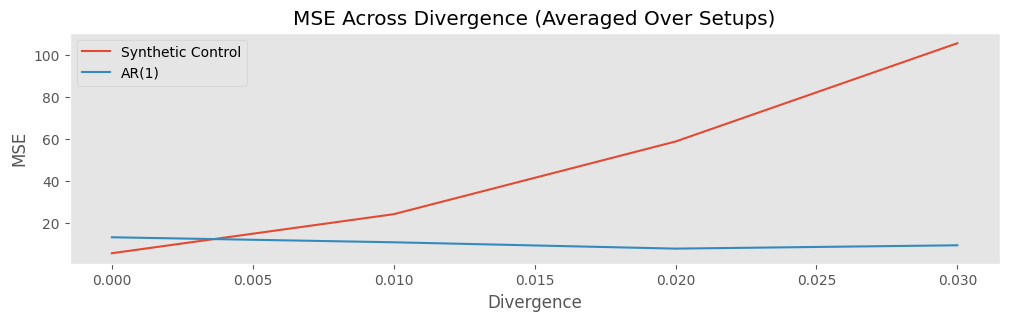

In [144]:
#run simulations -- increased variance
# Example usage
n_subjects = 100
n_competitors = 9
n_timesteps = 300
d = 5
sigmas = 0.1
competitor_correlation = 0.3
setups = ['A', 'B', 'C']
increase_trends = 0.01
divergence_trends = [0, 0.01, 0.02, 0.03]

# Run simulations
results_df2 = run_simulation(
    n_subjects, n_timesteps, d, sigmas, n_competitors, 
    competitor_correlation, setups, increase_trends, divergence_trends, n_runs=10
)

# Display results table
display(results_df2[['setup', 'sigma', 'n_competitors', 'increase_trend', 'divergence', 'mse_sc_avg', 'mse_sc_std','mse_ar1_avg','mse_ar1_std']])
plot_results(results_df2, comparison='Divergence')
